predicting:  clay
number of samples in prediction classes: 83 86
prediction iteration rmse_train r2_train rmse_test r2_test
clay 0 0.94 1.00 15.45 0.22 



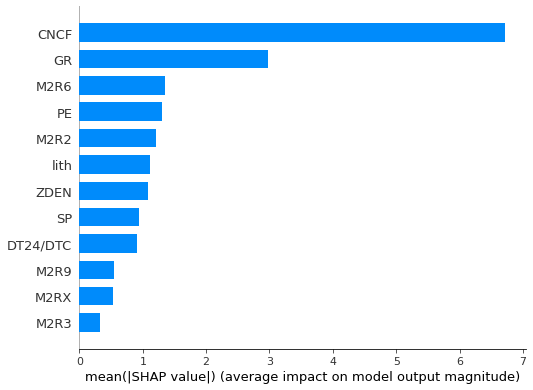

CNCF 0 10 6.7112
GR 0 3 2.9752
M2R6 0 6 1.3536
PE 0 11 1.3065
M2R2 0 4 1.2044
lith 0 1 1.1106
ZDEN 0 9 1.077
SP 0 12 0.9379
DT24/DTC 0 2 0.9031
M2R9 0 7 0.541
M2RX 0 8 0.5279
M2R3 0 5 0.3192

prediction iteration rmse_train r2_train rmse_test r2_test
clay 0 0.94 1.00 15.45 0.22 
clay 1 1.37 0.99 12.97 0.27 



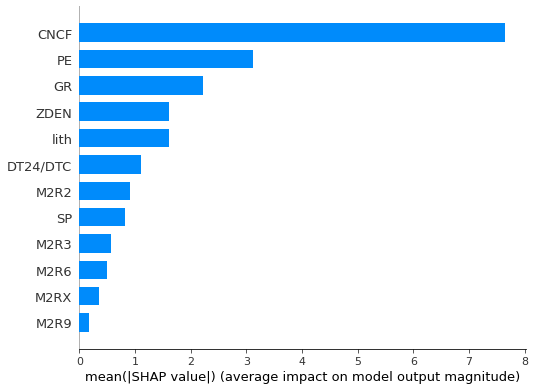

CNCF 1 10 7.6374
PE 1 11 3.1158
GR 1 3 2.2131
ZDEN 1 9 1.6078
lith 1 1 1.6075
DT24/DTC 1 2 1.1049
M2R2 1 4 0.9071
SP 1 12 0.824
M2R3 1 5 0.5612
M2R6 1 6 0.4944
M2RX 1 8 0.3465
M2R9 1 7 0.1802

prediction iteration rmse_train r2_train rmse_test r2_test
clay 0 0.94 1.00 15.45 0.22 
clay 1 1.37 0.99 12.97 0.27 
clay 2 1.47 0.99 16.00 0.34 



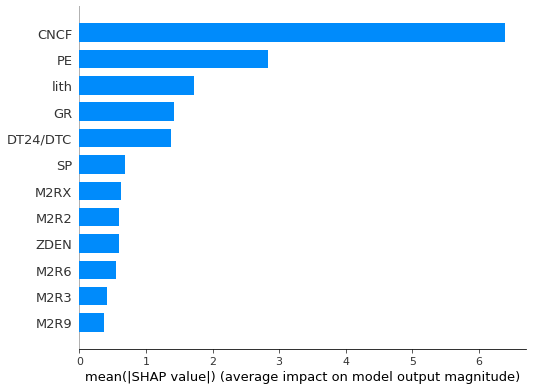

CNCF 2 10 6.3871
PE 2 11 2.8351
lith 2 1 1.726
GR 2 3 1.4215
DT24/DTC 2 2 1.3736
SP 2 12 0.6908
M2RX 2 8 0.6312
M2R2 2 4 0.6002
ZDEN 2 9 0.5922
M2R6 2 6 0.5524
M2R3 2 5 0.4064
M2R9 2 7 0.3694



KeyboardInterrupt: 

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar  7 12:00:08 2021

@author: mcbeck
"""
import statistics as stat
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
import shap

import random
from datetime import datetime
random.seed(datetime.now())

# make a binary prediction (above or below median) =1
# or make a continuum of predictions ==0
get_bin = 1

# decide to get shap values or not
get_shap = 1

# filename of the data
fname = 'pruned data_5.3.txt'
# features to use for predictions
# well_n depth lith DT24/DTC GR M2R2 M2R3 M2R6 M2R9 M2RX ZDEN CNCF PE SP clay silica carbonate
#features = ['lith','DT24/DTC', 'LnM','GR', 'GR_silica','GR_clay','M2R2','M2R3','M2R6','M2R9','M2RX',
#            'ZDEN','ZDENm', 'CNCF','CNCFm','CNCF_clay','TM','TP','TN','PE','SP']
#features = ['lith','DTC', 'LnM','GR', 'GR_silica','GR_clay','M2R2','M2R3','M2R6','M2R9','M2RX',
#            'ZDEN', 'CNCF','CNCF_clay','TM','TP','TN','PE','SP']
features = ['lith','DT24/DTC', 'GR' ,'M2R2','M2R3','M2R6','M2R9','M2RX',
            'ZDEN', 'CNCF','PE','SP']

numf = len(features)

# list of lab measurements to predict
preds = ['clay']
#preds = ['Silica']
#preds = ['carbonate']

for pred in preds:
    # filename of where to write the output
    score_txt = 'borehole_scores_'+pred+'_bin_'+str(get_bin)+'.txt'
    shap_txt = 'borehole_shap_'+pred+'_bin_'+str(get_bin)+'.txt'
    
    # read in the data
    df = pd.read_csv(fname, delim_whitespace=True)
    # drop the data that has nan in some row (where there are no measurements)
    df = df.dropna().copy()
    
    # scale the features
    df_scale = df.copy()
    trans = RobustScaler()
    df_scale[features] = trans.fit_transform(df_scale[features].values)
    
    # separate the predictions into above and below the mean or median of the population
    predvs = df_scale[pred].values
    #mid = stat.mean(predvs)
    
    print("predicting: ", pred)
    if get_bin:
        mid = stat.median(predvs)
        pred_bin = [1 if e>mid else 0 for i, e in enumerate(predvs)]
        df_scale["predict"] = pred_bin
        
        # count the number in each category
        num1 = sum(pred_bin)
        num0 = len(pred_bin)-num1
        print("number of samples in prediction classes:", num1, num0)
    else:
        df_scale["predict"] = predvs
        vmin = min(predvs)
        vmax= max(predvs)
        print("range of predictions:", vmin, vmax)
    
    
    score_str = "prediction iteration rmse_train r2_train rmse_test r2_test\n"
    shp_str = "feat_str it feat_num mean_shap \n";
        
    # make 10 different models that differ in how the training/testing data
    # is split
    it=0
    while it<30:
        # split into training and testing data set
        inds = np.random.uniform(0, 1, len(df_scale)) <= .70 
        
        df_scale['is_train'] = inds
        train, test = df_scale[df_scale['is_train']==True], df_scale[df_scale['is_train']==False]
        
        x_train = train[features]
        y_train = train[pred]
          
        x_test = test[features]
        y_test = test[pred]
        
        
        # weighted features
        # add features to explain subsets of data
        X = df_scale[features]
        y = df_scale[pred]
        data_dmatrix = xgb.DMatrix(data=X,label=y)
        
        # max_depth: Maximum depth of a tree. 
        # Increasing this value will make the model more complex and more likely to overfit
        # colsample_bytree: subsample ratio of columns when constructing each tree
        # alpha: L1 regularization term on weights. Default=0
        # Increasing this value will make model more conservative
        # learning_rate, eta = Typical final values to be used: 0.01-0.2
        xgb_clf = xgb.XGBRegressor(objective ='reg:squarederror')
        #xgb_clf = xgb.XGBClassifier(objective ='multi:softmax')
        #parameters = {'colsample_bytree':[0.7, 0.8, 0.9], 'alpha':[0, 3, 5], 
        #      'learning_rate': [0.1, 0.2, 0.3],
        #      'n_estimators': [100, 200, 300], 'max_depth':[3, 4, 5, 6]}
        parameters = {'colsample_bytree':[0.8, 0.9], 'alpha':[3, 5], 
              'learning_rate': [0.1],
              'n_estimators': [100, 200, 300], 'max_depth':[4, 5, 6]}

        
        grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=10, n_jobs=-1)
        
        grid_search.fit(x_train, y_train)
        xg_reg = grid_search.best_estimator_
        
        preds = xg_reg.predict(x_test)
        preds_train = xg_reg.predict(x_train)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, preds))
        
        r2_test = r2_score(y_test, preds)
        r2_train = r2_score(y_train, preds_train)
        
        score_str = score_str+"%s %d %.2f %.2f %.2f %.2f \n" % (pred, it, rmse_train, r2_train, rmse_test, r2_test)
    
        print(score_str)
    
        if r2_test>0.76:
            # test this model on the data without lab measurement
            # 1000 rows of data: 1000 prediction of carbonate for 1 model
            #xgb_clf.save_model('001.model')
            pickle.dump(xg_reg, open("pima_clay_.pickle.dat", "wb"))
            #dfu = pd.read_csv('data_all_predict.txt', delim_whitespace=True)
            #dfu_scale = dfu.copy()
            #trans = RobustScaler()
            #dfu_scale[features] = trans.fit_transform(dfu_scale[features].values)
            #x_unseen = dfu_scale[features]
            #clay = xg_reg.predict(x_unseen)
            #file = open('model_result.txt', mode='w')
            #file.write(str(clay)) 
            #file.close
            #print(clay)

            x_train_best = train[features]
            y_train_best = train[pred]            
            x_test_best = test[features]
            y_test_best = test[pred]   
            best_train = np.append(x_train_best,y_train_best[:,None],axis=1)
            best_test = np.append(x_test_best,y_test_best[:,None],axis=1)
            
            
            np.savetxt('best train data_clay.txt',(best_train))
            np.savetxt('best test data_clay.txt',(best_test))
                      

            #file = open('best train data.txt', mode='w')
            #file.write (str(x_train_best))
            #file.write (str(y_train_best))
            #file.close
            
        #if r2_test<0.3:
        #    x_train_worst = train[features]
        #    y_train_worst = train[pred]           
        #    x_test_worst = test[features]
        #    y_test_worst = test[pred]     
            
        #    worst_train = np.append(x_train_worst,y_train_worst[:,None],axis=1)
        #    worst_test = np.append(x_test_worst,y_test_worst[:,None],axis=1)
            
            
        #    np.savetxt('worst train data.txt',(worst_train))
        #    np.savetxt('worst test data.txt',(worst_test))
    
        if get_shap:
            shap_vals = shap.TreeExplainer(xg_reg).shap_values(train[features], check_additivity=False)
            
            shap.summary_plot(shap_vals, train[features], plot_type="bar")
            shap_comb = shap_vals.transpose()
            
            shap_mean = []
            num_f = len(shap_comb)
            for fi in range(len(shap_comb)):              
                vabs = abs(shap_comb[fi])
                v_mean = stat.mean(vabs)       
                shap_mean.append(v_mean)
        
            shapl = list(zip(features, shap_mean, range(1, numf+1)))
            shapl.sort(key=lambda tup: tup[1], reverse=True)
                
            shps = ""
            for ft in shapl:
                shps = shps+ft[0]+" "+str(it)+" "+str(ft[2])+" "+str(round(ft[1], 4))+"\n"
            
            print(shps)
            shp_str = shp_str+shps
                    
        it=it+1

    # write scores to textfile
    f= open(score_txt, "w")
    f.write(score_str)
    f.close()
    print(score_txt)
    
    if get_shap:
        # write scores to textfile
        f= open(shap_txt, "w")
        f.write(shp_str)
        f.close()
        print(shap_txt)